<a href="https://colab.research.google.com/github/YuriGribauskasDenis/NetworkTopologies/blob/main/GoogleNetFamilyTopologies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import keras
import keras.backend as BCKN
from keras.models import Model
from keras.layers import Input, Concatenate, Add
from keras.layers import Dense, Conv2D, Flatten, Dropout, SeparableConv2D
from keras.layers import MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from keras.layers import ReLU, Softmax
from keras.layers import BatchNormalization as BN
from keras.utils.vis_utils import plot_model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1024, 1024,  0           []                               
                                 3)]                                                              
                                                                                                  
 batch_normalization (BatchNorm  (None, 1024, 1024,   12         ['input_1[0][0]']                
 alization)                     3)                                                                
                                                                                                  
 re_lu (ReLU)                   (None, 1024, 1024,   0           ['batch_normalization[0][0]']    
                                3)                                                            

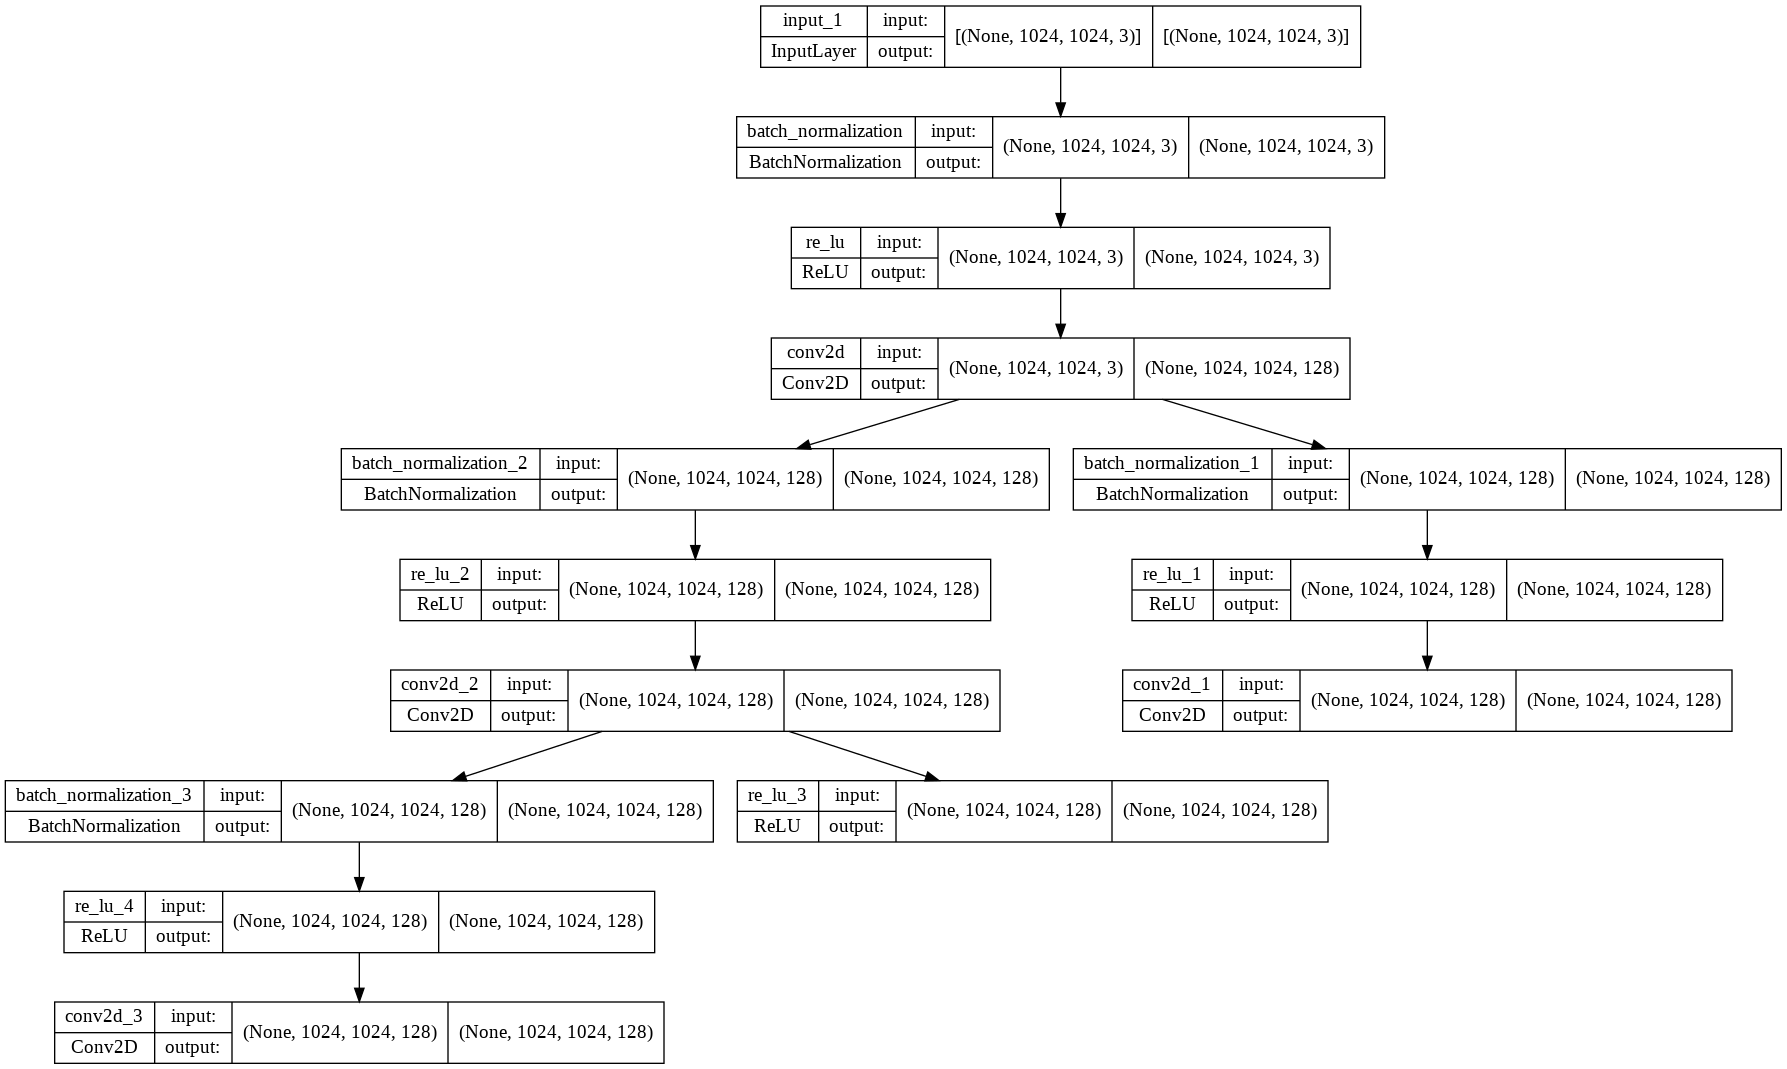

In [3]:
#let's train to make output from the middle part of net
shape = (1024, 1024, 3)
num_classes = 1000

def BNRC(model, filters, kernal, strdide=1):
  model = BN() (model)
  model = ReLU() (model)
  model = Conv2D(filters, kernal, strides=strdide, padding='same') (model)
  return model

BCKN.clear_session()
first = Input(shape)
inside = BNRC(first, 4*32, 1)
output01 = BNRC(inside, 4*32, 1)
inside = BNRC(inside, 4*32, 1)
output02 = ReLU() (inside)
inside = BNRC(inside, 4*32, 1)
model = Model(first, [inside, output01, output02])
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Google Net**


Only relu activation is to be used. no batch normalization inside blocks

In [4]:
def GNet (shape, num_classes, training=0):

  #the training variable is needed because
  #the topology for training differs from the one for contest

  #just copying table
  #i could not recognize any pattern
  #so just copy
  a3= 64, 96,128, 16, 32, 32
  b3=128,128,192, 32, 96, 64
  a4=192, 96,208, 16, 48, 64
  b4=160,112,224, 24, 64, 64
  c4=128,128,256, 24, 64, 64
  d4=112,144,288, 32, 64, 64
  e4=256,160,320, 32,128,128
  a5=e4
  b5=384,192,384, 48,128,128

  #we use only relu, we choose where to put normalization
  #we'll do as in paper
  #we shall use batch normalization
  #our teacher taught us it is preferable
  #but no normalization inside inception block

  def CR(model, filters, kernal, stride=1, padd='valid'):
    model = Conv2D (filters, kernal, strides=stride, padding=padd) (model)
    model = ReLU() (model)
    return model

  #pooling accures separately so we did nit change it to any automatization
  first = Input(shape)
  model = CR(first, 64, 7, 2, 'same')
  model = MaxPooling2D(3, strides=2, padding='same') (model)
  model = BN() (model)
  model = CR(model, 64, 1)
  model = CR(model, 192, 3, 1, 'same')
  model = BN() (model)
  model = MaxPooling2D(3, strides=2, padding='same') (model)

  #inception block
  #this is separation into different lines or columns
  #depending on picture orientation
  #we call them branches
  #as said - only relu
  #the filter kernels are the same so we use a constants
  #the numbers of filters are in list
  def IB (model, filters, padd='same'):
    branch01 = CR(model, filters[0], 1)
    branch02 = CR(model, filters[1], 1)
    branch02 = CR(branch02, filters[2], 3, 1, padd)
    branch03 = CR(model, filters[3], 1)
    branch03 = CR(branch03, filters[4], 5, 1, padd)
    branch04 = MaxPooling2D(3, strides=1, padding=padd) (model)
    branch04 = CR(branch04, filters[5], 1)
    model = Concatenate()([branch01, branch02, branch03, branch04])
    return model

  #training out block
  #as i understood this was used for training
  #so we made it
  def TOB(model, filters=128):
    model = AveragePooling2D(5, strides=3, padding="valid") (model)
    model = CR(model, filters, 5, 1, 'same')
    model = Dense(1024) (model)
    model = ReLU() (model)
    model = Dropout(0.7) (model)
    model = Flatten()(model)
    model = Dense(num_classes) (model)
    model = Softmax() (model)
    return model

  model = IB (model, a3)
  model = IB (model, b3)
  model = MaxPooling2D(3, strides=2, padding='same') (model)
  model = IB (model, a4)
  if training:
    extraction01 = TOB(model)
  model = IB (model, b4)
  model = IB (model, c4)
  model = IB (model, d4)
  if training:
    extraction02 = TOB(model)
  model = IB (model, e4)
  model = MaxPooling2D(3, strides=2, padding='same') (model)
  model = IB (model, a5)
  model = IB (model, b5)

  #tail
  model = GlobalAveragePooling2D() (model)
  model = Dropout(0.4) (model)
  model = Dense(num_classes) (model)
  last = Softmax() (model)
  if training:
    final = Model(first, [last, extraction01, extraction02])
  else:
    final = Model(first, last)

  return final

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 re_lu (ReLU)                   (None, 112, 112, 64  0           ['conv2d[0][0]']                 
                                )                                                             

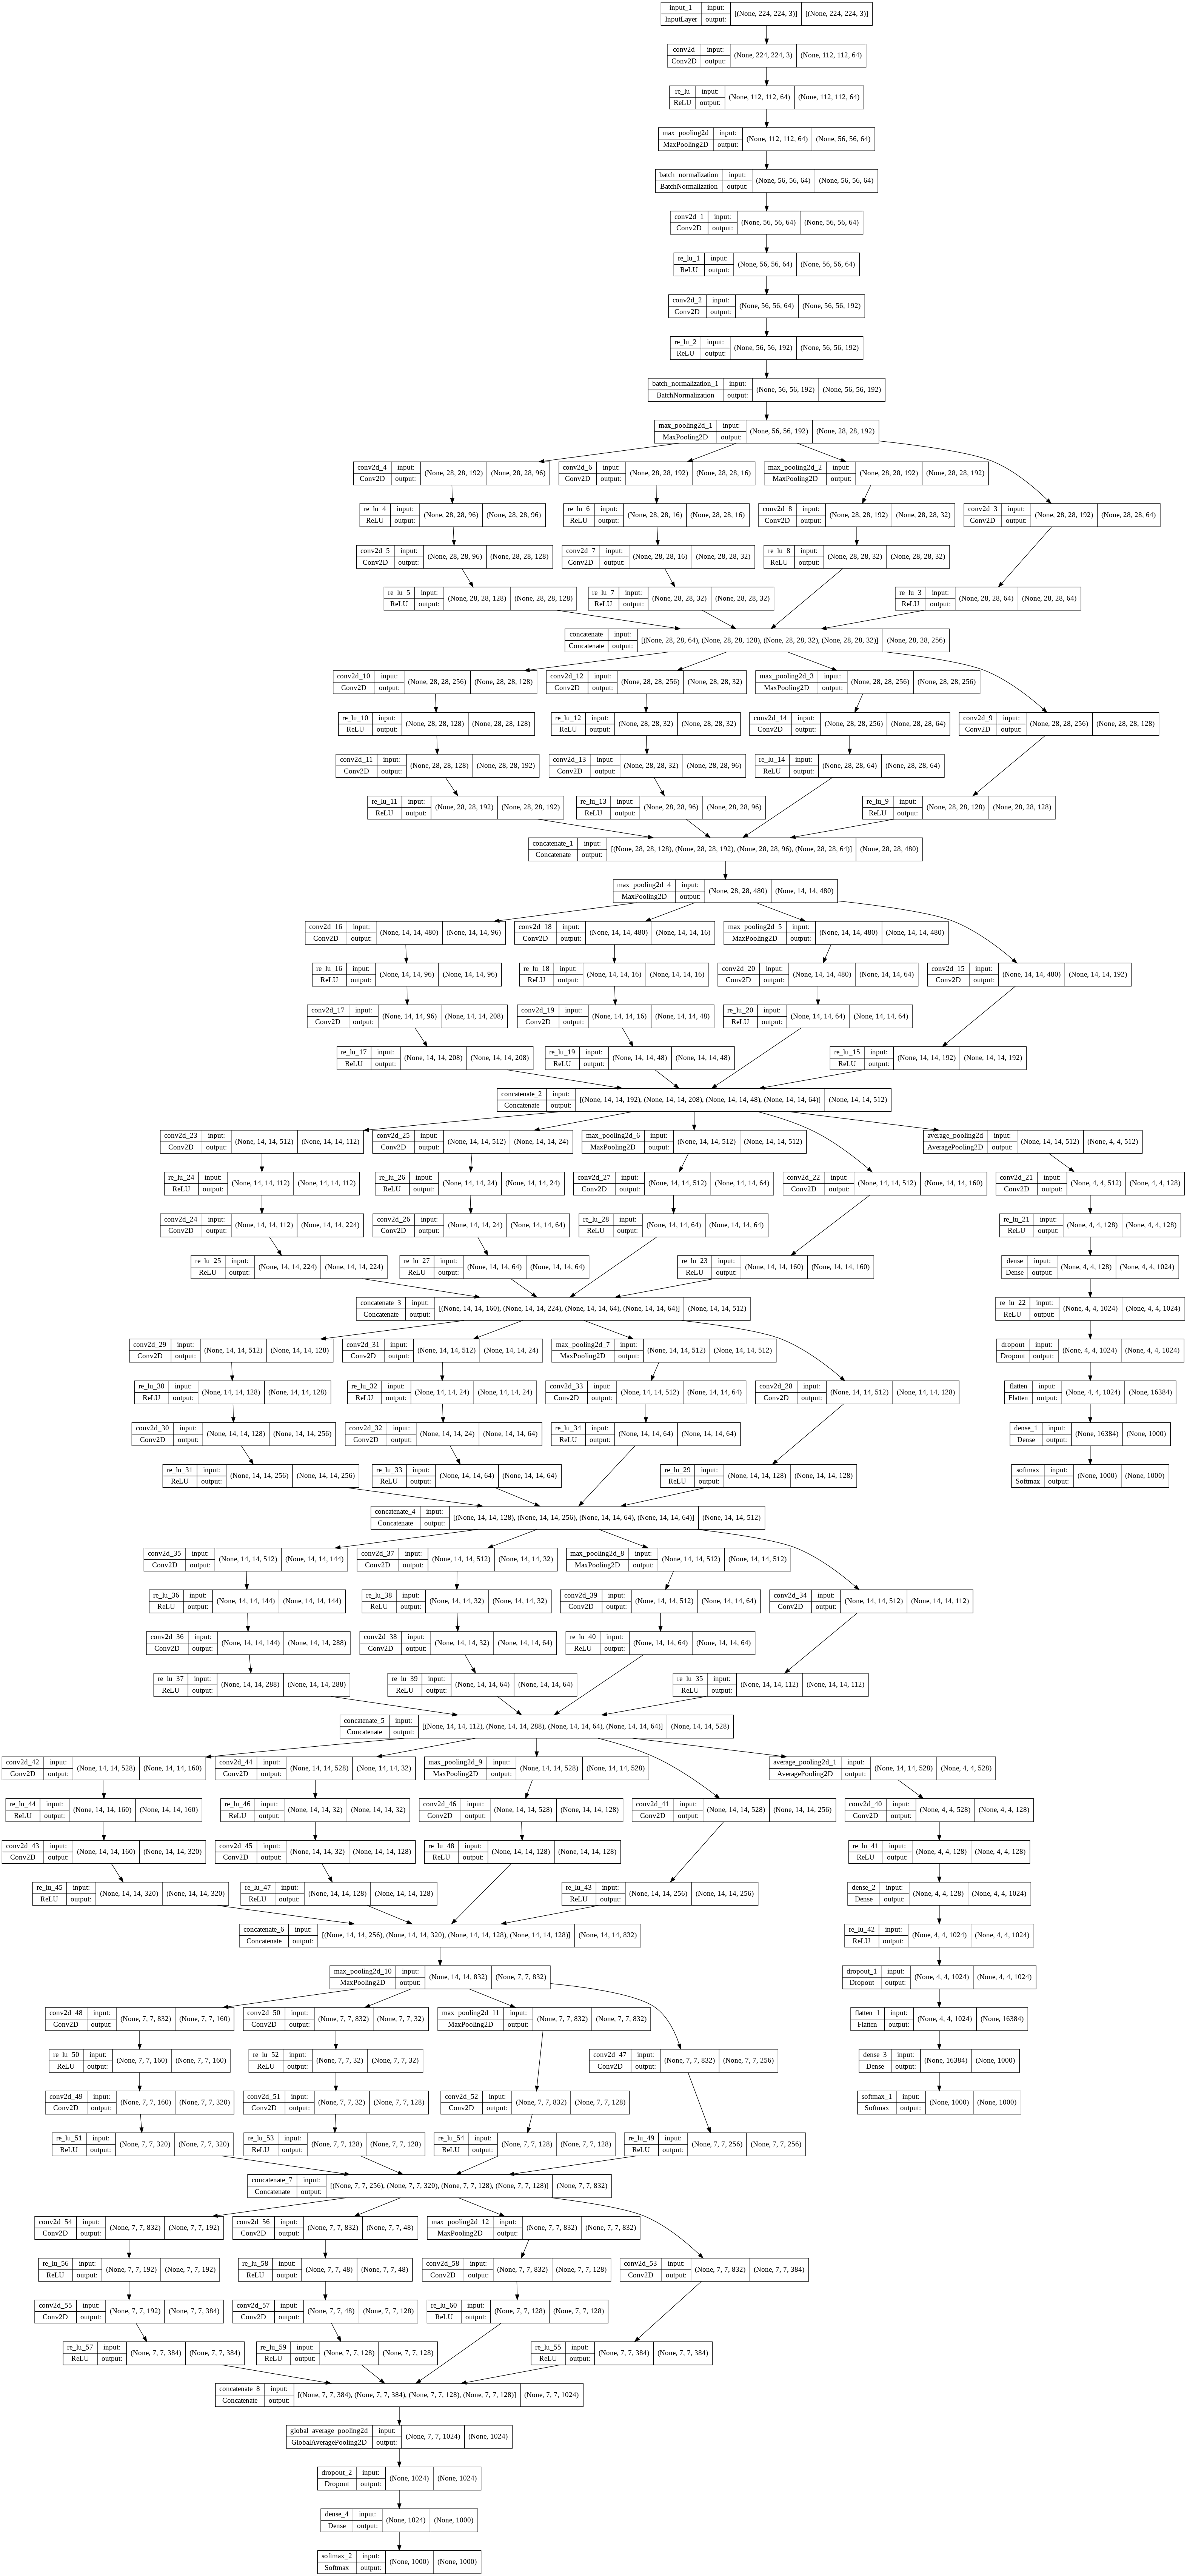

In [5]:
shape = (224, 224, 3)
num_classes = 1000
t = 'whatever'
BCKN.clear_session()
model = GNet(shape, num_classes, t)
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Exception Google Net**

In [6]:
def XNet (shape, num_classes):

  #unique case when everything is done in functions :)

  #our usual convolution batch normalization block
  def CBN(model, filters, kernal, stride=1, padd='same'):
    model = Conv2D(filters, kernal, strides=stride, padding=padd)(model)
    model = BN()(model)
    return model

  def CBNR(model, filters, kernal, stride=1, padd='same'):
    model = CBN(model, filters, kernal, stride, padd)
    model = ReLU() (model)
    return model

  #brother convolution batch normalization block
  #with separable convolution
  def SCBN(model, filters, kernal, stride=1, padd='same'):
    model = SeparableConv2D(filters, kernal, strides=stride, padding=padd)(model)
    model = BN()(model)
    return model

  #we need this
  def RSCBN(model, filters, kernal, stride=1, padd='same'):
    model = ReLU() (model)
    model = SCBN(model, filters, kernal, stride, padd)
    return model

  #yes, this we need too
  def SCBNR(model, filters, kernal, stride=1, padd='same'):
    model = SCBN(model, filters, kernal, stride, padd)
    model = ReLU() (model)
    return model

  #early flow
  def ENF(model,):
    model = CBNR(model, 32, 3, 2)
    inside = CBNR(model, 32, 3)
    model = SCBN(inside, 128, 3)
    model = RSCBN(model, 128, 3)
    model = MaxPooling2D(3, strides=2, padding='same') (model)
    inside = CBN(inside, 128, 1, 2)
    model = Add() ([model, inside])
    model = RSCBN(model, 256, 3)
    model = RSCBN(model, 256, 3)
    model = MaxPooling2D(3, strides=2, padding='same') (model)
    inside = CBN(inside, 256, 1, 2)
    model = Add() ([model, inside])
    model = RSCBN(model, 728, 3)
    model = RSCBN(model, 728, 3)
    model = MaxPooling2D(3, strides=2, padding='same') (model)
    inside = CBN(inside, 728, 1, 2)
    model = Add() ([model, inside])
    return model

  #middle flow
  def MDF(model):
    for _ in range(8):
      inside = RSCBN(model, 728, 3)
      inside = RSCBN(inside, 728, 3)
      inside = RSCBN(inside, 728, 3)
      model = Add()([model, inside])
    return model

  #exit flow
  def EXF(model):
    inside = RSCBN(model, 728, 3)
    inside = RSCBN(inside, 1024, 3)
    inside = MaxPooling2D(3, strides=2, padding='same') (inside)
    model = CBN(model, 1024, 1, 2)
    inside = Add() ([inside, model])
    inside = SCBNR(inside, 1536, 3)
    inside = SCBNR(inside, 2048, 3)
    #noncanonical end but it is we who dicide when to end
    return inside
  
  first = Input(shape)
  model = ENF(first)
  model = MDF(model)
  model = EXF(model)
  model = GlobalAveragePooling2D() (model)
  model = Dense(2048) (model)
  model = Dense(2048) (model)
  model = Dense(num_classes) (model)
  last = Softmax() (model)
  
  final = Model(first, last)

  return final

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 150, 150, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

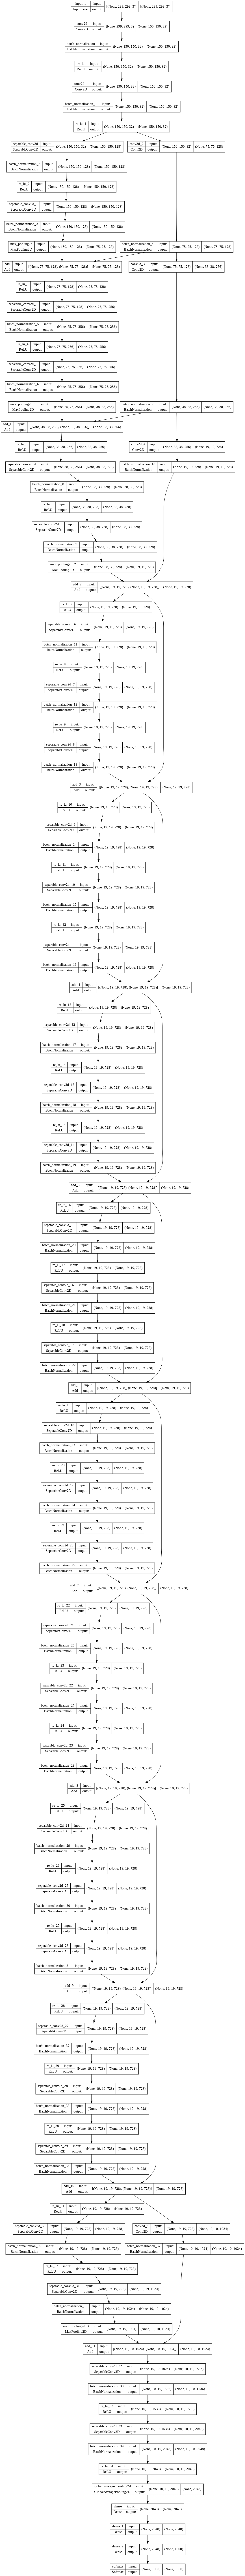

In [7]:
shape = (299, 299, 3)
num_classes = 1000
BCKN.clear_session()
model = XNet(shape, num_classes)
model.summary()
#sadly the number of parameters is wrong, but we'll figure it out in future
#after figuring out right number of parameters for resnet family
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)